# Starbucks Capstone Challenge - Data Understanding

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sb_capstone.wrangling import (
    clean_portfolio, 
    clean_profile, 
    clean_transcript,
    ChannelType
)

from sb_capstone.shaping import (
    get_transcript_active,
    get_transcript_group,
    get_transcript_sequence
)

%matplotlib inline

np.set_printoptions(suppress=True)
base_color = sns.color_palette()[0]

In [3]:
portfolio = pd.read_csv("../data/processed/portfolio.csv")
portfolio = clean_portfolio(portfolio)
portfolio.head()

,id,offer_type,channels,reward,difficulty,duration
0,1,bogo,"[email, mobile, social]",10,10,7
1,2,bogo,"[web, email, mobile, social]",10,10,5
2,3,informational,"[web, email, mobile]",0,0,4
3,4,bogo,"[web, email, mobile]",5,5,7
4,5,discount,"[web, email]",5,20,10


In [4]:
profile = pd.read_csv("../data/processed/profile.csv")
profile = clean_profile(profile)
profile.head()

,id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


In [5]:
transcript = pd.read_csv("../data/processed/transcript.csv")
transcript = clean_transcript(transcript)
transcript.head()

,person_id,event,time,offer_id,amount,reward
0,4,offer_received,0,4,NaN,NaN
1,4,offer_viewed,6,4,NaN,NaN
2,4,transaction,132,0,19.89,NaN
3,4,offer_completed,132,4,NaN,5.0
4,4,transaction,144,0,17.78,NaN


## Data Analysis

### Understand Portfolio Table

The `portfolio` table contains the offers and its details. This section aims to understand how it is setup and how conservative the setup are. We're going to look at if there are any relationship with regards to the rewards and difficulty with duration. We're going to see as well if there are any patterns in the data.

#### Univariate

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          10 non-null     int64   
 1   offer_type  10 non-null     category
 2   channels    10 non-null     object  
 3   reward      10 non-null     int64   
 4   difficulty  10 non-null     int64   
 5   duration    10 non-null     int64   
dtypes: category(1), int64(4), object(1)
memory usage: 670.0+ bytes


Only `10` offers made. No missing values.

Since there are only ten items. We can perform visual inspection to the whole data and observe any patterns. We sorted by `duration`, `difficulty`, and `reward`.

In [7]:
portfolio.sort_values(by=["duration", "difficulty", "reward"], ascending=False)

,id,offer_type,channels,reward,difficulty,duration
4,5,discount,"[web, email]",5,20,10
6,7,discount,"[web, email, mobile, social]",2,10,10
0,1,bogo,"[email, mobile, social]",10,10,7
9,10,discount,"[web, email, mobile]",2,10,7
5,6,discount,"[web, email, mobile, social]",3,7,7
3,4,bogo,"[web, email, mobile]",5,5,7
1,2,bogo,"[web, email, mobile, social]",10,10,5
8,9,bogo,"[web, email, mobile, social]",5,5,5
2,3,informational,"[web, email, mobile]",0,0,4
7,8,informational,"[email, mobile, social]",0,0,3


Buy-One-Get-One (`bogo`) offer has the same `reward` and difficulty. Combinations varies and a bit conservative except for `bogo`. The `portfolio` table's most expensive visually are the `bogo` offers while the cheapest ones are the `informational` types.

Next, is let's try to describe the `portfolio` table see if there are any glaring patterns.

In [8]:
portfolio.describe(include="all")

,id,offer_type,channels,reward,difficulty,duration
count,10.00000,10,10,10.000000,10.000000,10.000000
unique,NaN,3,4,NaN,NaN,NaN
top,NaN,bogo,"[web, email, mobile, social]",NaN,NaN,NaN
freq,NaN,4,4,NaN,NaN,NaN
mean,5.50000,NaN,NaN,4.200000,7.700000,6.500000
std,3.02765,NaN,NaN,3.583915,5.831905,2.321398
min,1.00000,NaN,NaN,0.000000,0.000000,3.000000
25%,3.25000,NaN,NaN,2.000000,5.000000,5.000000
50%,5.50000,NaN,NaN,4.000000,8.500000,7.000000
75%,7.75000,NaN,NaN,5.000000,10.000000,7.000000


A few notable items here:

* Rewards are up to 10 and difficulty is up to 20. Perhaps this make sense, as the price of coffee would probably on that range.
* Top channel used includes all media (`web`, `email`, `mobile`, `social`)

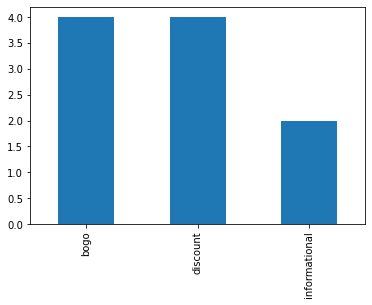

In [9]:
portfolio.offer_type.value_counts().plot(kind="bar");

Balance distribution of different offer types, 4 `bogo` and `discount` offer types and 2 `informational`.

Next we'll look at the different channels and how are they distributed.

In [10]:
portfolio.channels.explode().astype(ChannelType).value_counts()

email     10
mobile     9
web        8
social     6
Name: channels, dtype: int64

`email` and `mobile` tops the list.

#### Bivariate and Multivariate

Let's look at which offer in the portfolio table is the most expensive and the cheapest.

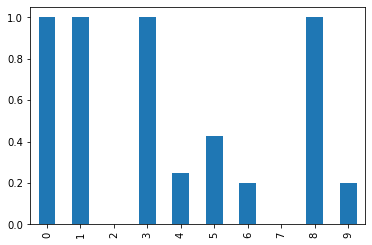

In [11]:
portfolio_price = portfolio.copy()

portfolio_price["reward_pct"] = (portfolio_price.reward/portfolio_price.difficulty).fillna(0)
portfolio_price.reward_pct.plot(kind="bar");

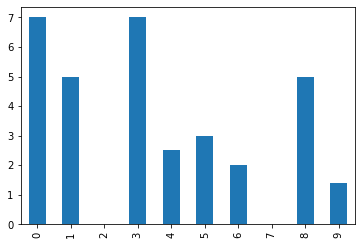

In [12]:
portfolio_price["reward_ot"] = portfolio_price.reward_pct * portfolio_price.duration
portfolio_price.reward_ot.plot(kind="bar");

`bogo` offers are of course the more expensive ones. When we add duration, `bogo` offers are still the most expensive and we can see as well which one stands out as they are ran longer.

We also don't have a price tag on how expensive each channels are, but we can perhaps pull out which one are used mostly with aspect of duration.

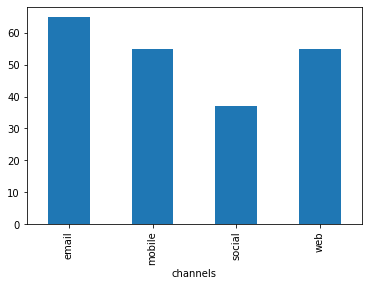

In [13]:
portfolio_price \
    .explode(column="channels") \
    .groupby("channels") \
    .duration \
    .sum() \
    .plot(kind="bar");

`email` is the most used channel based on duration. This may tell us story on which channel is easier/cheaper to implement.

### Understand Profile Table

Profile contains short description of customers under study. We'll try to understand types of customers we are trying to study.

Let's look first what data are available and some summary.

#### Univariate

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                17000 non-null  int64         
 1   gender            14825 non-null  category      
 2   age               14825 non-null  float64       
 3   income            14825 non-null  float64       
 4   became_member_on  17000 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 548.1 KB


In [15]:
profile.describe(include="all", datetime_is_numeric=True)

,id,gender,age,income,became_member_on
count,17000.000000,14825,14825.000000,14825.000000,17000
unique,NaN,3,NaN,NaN,NaN
top,NaN,M,NaN,NaN,NaN
freq,NaN,8484,NaN,NaN,NaN
mean,8500.500000,NaN,54.393524,65404.991568,2017-02-23 13:12:10.164706048
min,1.000000,NaN,18.000000,30000.000000,2013-07-29 00:00:00
25%,4250.750000,NaN,42.000000,49000.000000,2016-05-26 00:00:00
50%,8500.500000,NaN,55.000000,64000.000000,2017-08-02 00:00:00
75%,12750.250000,NaN,66.000000,80000.000000,2017-12-30 00:00:00
max,17000.000000,NaN,101.000000,120000.000000,2018-07-26 00:00:00


Profile features included are `age`, `gender`, `income`, `become_member_on`. There are missing values in `gender`, `age` and `income`, and they have the same amount of missing values. Are the missing values attributed to the same customer?

In [16]:
null_profiles = profile[ \
        profile.gender.isna() & \
        profile.age.isna() & \
        profile.income.isna()] \
        [["id", "gender", "became_member_on"]] 

null_profiles.describe(datetime_is_numeric=True)

,id,became_member_on
count,2175.000000,2175
mean,8517.805517,2017-03-29 19:53:42.620689920
min,1.000000,2013-08-02 00:00:00
25%,4006.500000,2016-07-04 12:00:00
50%,8542.000000,2017-07-31 00:00:00
75%,12855.000000,2017-12-26 00:00:00
max,16995.000000,2018-07-26 00:00:00
std,4985.473324,NaN


In [17]:
missing_gender = len(profile[profile.gender.isna()])
all_missing = len(null_profiles) 

print(f"Number of customers with missing gender: {missing_gender}")
print(f"Number of customers with missing gender, age, and income: {missing_gender}")

Number of customers with missing gender: 2175
Number of customers with missing gender, age, and income: 2175


Looks like when customer has missing gender, it goes to say that age and income are also missing. We'll note this information for now. The question, is it safe to remove them? We'll try to understand further the data.

Let's look more closely at the `gender` data.

In [18]:
profile.gender.value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

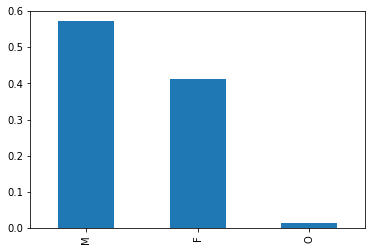

In [19]:
profile.gender.value_counts(normalize=True).plot(kind="bar");

There are more male customers (57%) than female (41%) but not that much. A bit more than 1% are unspecified.

Let's decribe the `age` data.

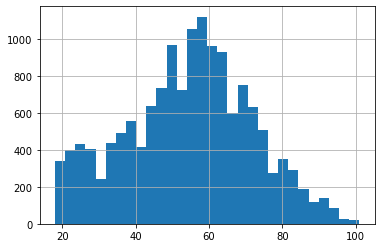

In [20]:
profile.age.hist(bins=30);

In [21]:
profile.age.mean(), profile.age.median(), profile.age.mode()[0]

(54.39352445193929, 55.0, 58.0)

Age has normal distribution (symmetrical), mostly from 50's to 60's. It's also inline with the global statistics. (https://www.statista.com/statistics/250091/coffee-drinking-consumers-in-the-us-by-age-group-2010/)

Expanding our analysis on age, we can look at the age groups.

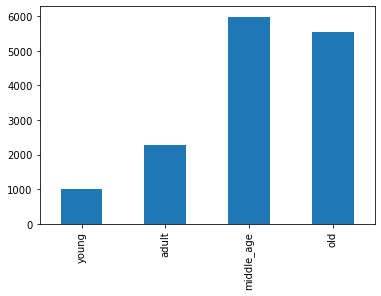

In [22]:
profile_age = profile.copy()
profile_age["group"] = pd.cut(profile_age.age, bins=[17, 25, 40, 60, 101], labels=["young", "adult", "middle_age", "old"])

profile_age.group.value_counts().sort_index(axis=0).plot(kind="bar");

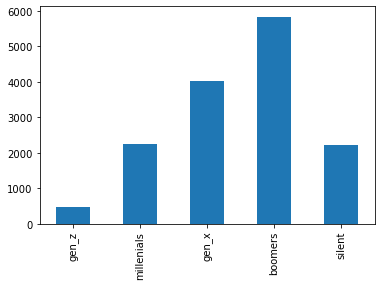

In [23]:
year = 2018

profile_age["generation"] = pd.cut( \
    profile_age.age, \
    bins=[17, year-1997, year-1981, year-1965, year-1946, 101], \
    labels=["gen_z", "millenials", "gen_x", "boomers", "silent"] \
)

profile_age.generation.value_counts().sort_index(axis=0).plot(kind="bar");

It's really noticeable that as you grow older, you like coffee more. The graphs shows that `middle_age` adult and `boomers` (40-60) are the ones mostly who likes coffee.

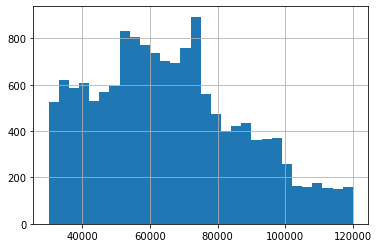

In [24]:
profile.income.hist(bins=30);

In [25]:
profile.income.mean(), profile.income.median(), profile.income.mode()[0]

(65404.9915682968, 64000.0, 73000.0)

Income distribution is right-skewed. This is true, since having Starbucks coffee appeals more to premium customers.

Next is the membership date. This is perhaps one of the important information we can focus more. Becoming a member, means we can get more customer profile and we can fine tune further our offers later.

In [26]:
profile.became_member_on.dt.year.value_counts(normalize=True)

2017    0.380529
2018    0.246941
2016    0.207412
2015    0.107647
2014    0.040647
2013    0.016824
Name: became_member_on, dtype: float64

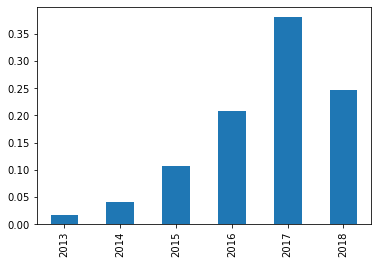

In [27]:
profile.became_member_on.dt.year.value_counts(normalize=True).sort_index(axis=0).plot(kind="bar");

In [28]:
profile.became_member_on.dt.month.value_counts(normalize=True)

8     0.094706
10    0.092235
12    0.091529
1     0.089706
9     0.089118
11    0.085235
7     0.079941
3     0.078176
4     0.077353
5     0.076882
6     0.074412
2     0.070706
Name: became_member_on, dtype: float64

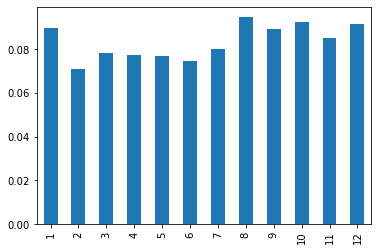

In [29]:
profile.became_member_on.dt.month.value_counts(normalize=True).sort_index(axis=0).plot(kind="bar");

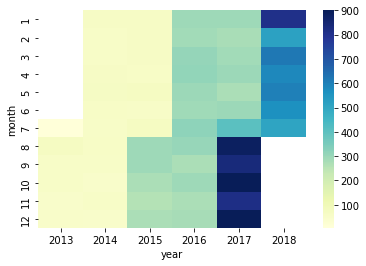

In [30]:
profile_date = profile.copy()
profile_date["month"] = profile.became_member_on.dt.month
profile_date["year"] = profile.became_member_on.dt.year

sns.heatmap( \
    profile_date \
        .groupby(by=["year", "month"]) \
        .became_member_on \
        .count() \
        .reset_index() \
        .pivot("month", "year", "became_member_on"), \
    cmap="YlGnBu" \
);

Membership dates from early 2013 to mid 2018. The data did not show however, if the offer started along those dates. We'll note that for now.

Most joiners are during 2017 (38%), and we've seen membership growth trends which only dip in 2018. New joiners are distributed almost equally on different months.

There's also burst of joiners from August 2017 to January 2018.

#### Bivariate and Multivariate

Let's start first with how `gender` distribution with `age`.

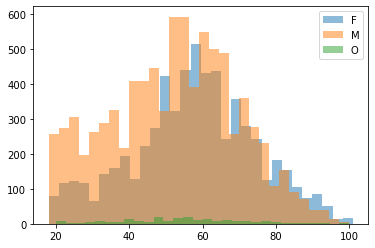

In [31]:
for g in profile.gender.dropna().unique():
    plt.hist(profile[profile.gender == g].age, bins=30, alpha=0.5, label=g)

plt.legend()
plt.show()

The normal distribution is more visible with `Female`, but visually, the peaks are still the same with `male`.

On the topic of `gender`, let's look closely its distribution with `income`.

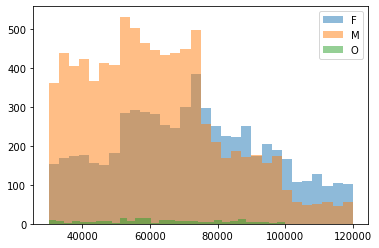

In [32]:
for g in profile.gender.dropna().unique():
    plt.hist(profile[profile.gender == g].income, bins=30, alpha=0.5, label=g)

plt.legend()
plt.show()

Again the distribution is more normal with `Female` customers, and the peak is still the same. This also means that at lower income bracket, men are more likely to spend more than women.

Now, let's see the distribution of gender for each year.

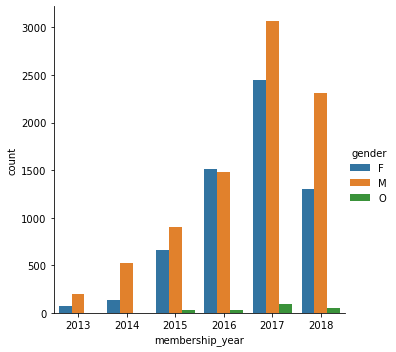

In [33]:
profile_date = profile.copy()
profile_date["membership_year"] = profile_date.became_member_on.dt.year
profile_date["membership_month"] = profile_date.became_member_on.dt.month

sns.catplot(data = profile_date, kind="count", x="membership_year", hue="gender", ci=None);

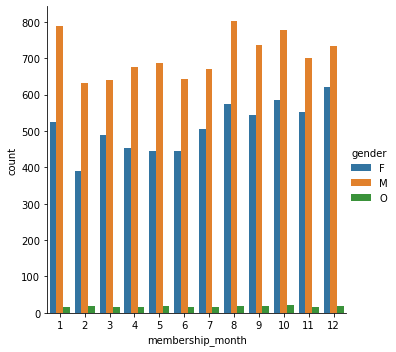

In [34]:
sns.catplot(data = profile_date, kind="count", x="membership_month", hue="gender", ci=None);

A bit consistent with what we've seen so far. On the yearly membership view, `Female` customers consistently caught up from 2013 to 2016, after that `Male` coffee drinkers took a huge growth in 2017 and 2018.

Moving on from gender, let's understand better the relationship of age and income.

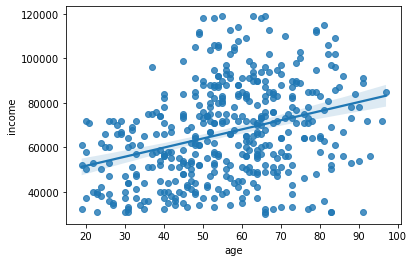

In [35]:
profile_sub = profile_age.sample(frac=0.03, random_state=42)

sns.regplot(data = profile_sub, x="age", y="income");

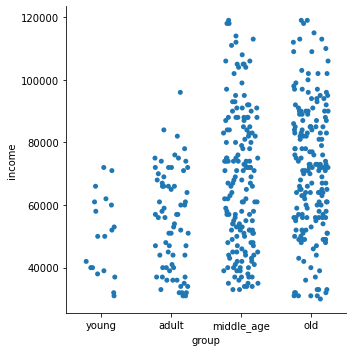

In [36]:
sns.catplot(data = profile_sub, x="group", y="income", jitter=0.25, color=base_color);

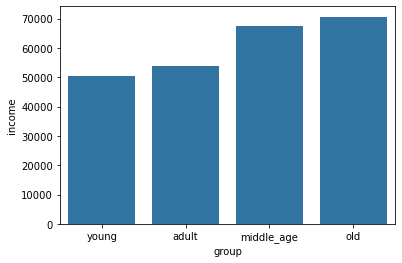

In [37]:
sns.barplot( \
    data=profile_age.groupby("group").income.mean().reset_index(), \
    x="group", \
    y ="income", \
    ci=None, \
    color=base_color);

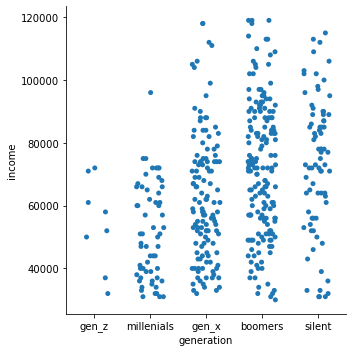

In [38]:
sns.catplot(data = profile_sub, x="generation", y="income", jitter=0.25, color=base_color);

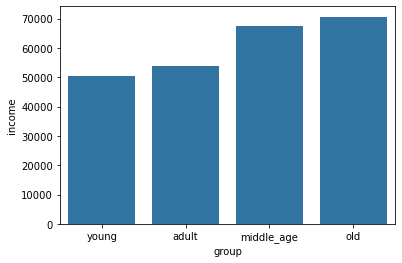

In [39]:
sns.barplot( \
    data=profile_age.groupby("group").income.mean().reset_index(), \
    x="group", \
    y ="income", \
    ci=None, \
    color=base_color);

We can see a small trend that as customer age, there's an increase in income. However, the points are too scattered from the mean. It also validates, that from `middle_age` or `gen_x` have higher range of income.

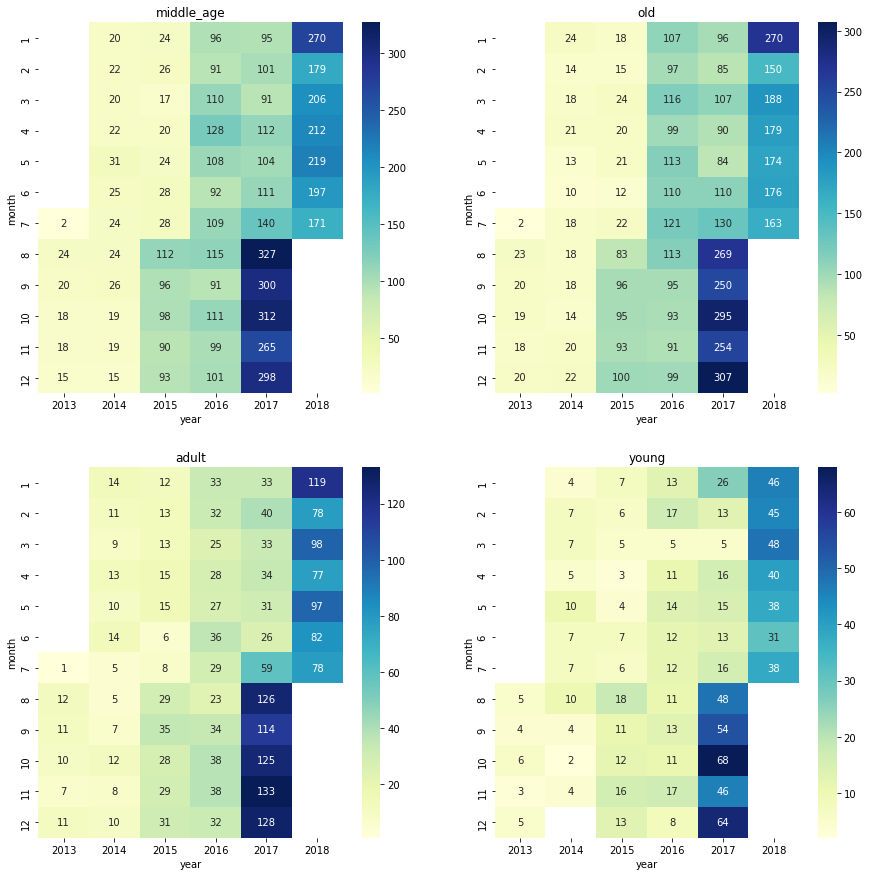

In [40]:
profile_age_date = profile_age.copy()
profile_age_date["month"] = profile_age_date.became_member_on.dt.month
profile_age_date["year"] = profile_age_date.became_member_on.dt.year

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
index = 0

for gr in profile_age_date.group.dropna().unique():
    a = axes[index // 2, index % 2]
    a.set_title(gr)

    sns.heatmap( \
        profile_age_date[profile_age_date.group==gr] \
            .groupby(by=["year", "month"]) \
            .became_member_on \
            .count() \
            .reset_index() \
            .pivot("month", "year", "became_member_on"),\
        annot=True, \
        fmt="g", \
        cmap="YlGnBu", \
        ax=a
    )

    index = index + 1


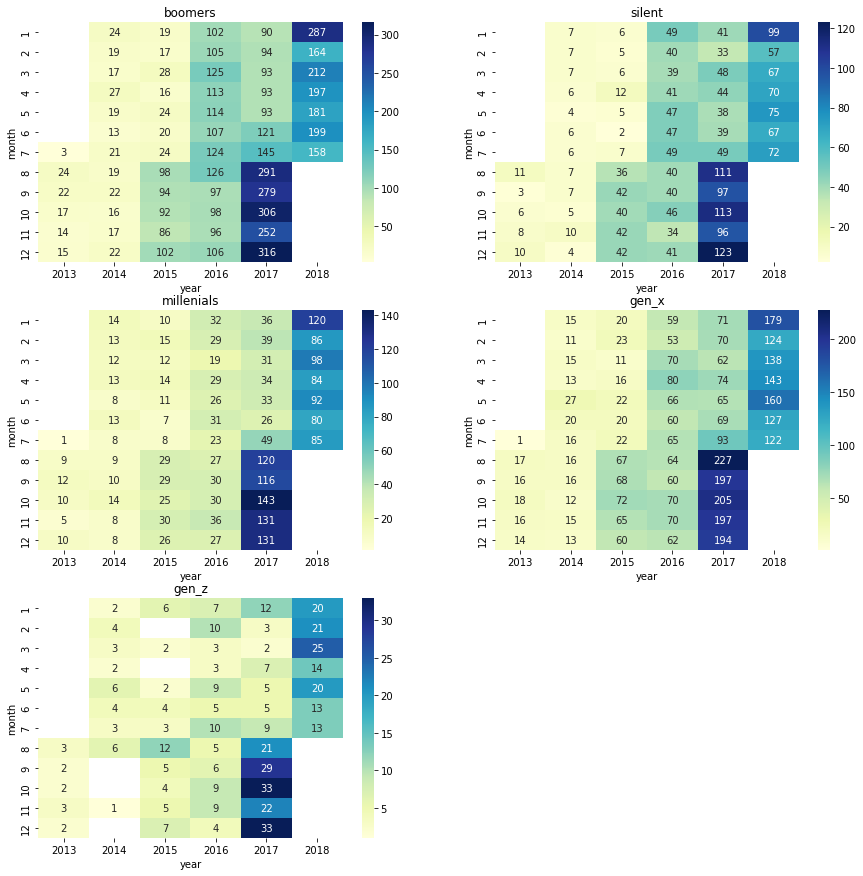

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
index = 0

for gn in profile_age_date.generation.dropna().unique():
    a = axes[index // 2, index % 2]
    a.set_title(gn)

    sns.heatmap( \
        profile_age_date[profile_age_date.generation==gn] \
            .groupby(by=["year", "month"]) \
            .became_member_on \
            .count() \
            .reset_index() \
            .pivot("month", "year", "became_member_on"),\
        cmap="YlGnBu", \
        fmt="g", \
        annot=True, \
        ax=a
    )

    index = index + 1

fig.delaxes(ax=axes[2, 1])

It's consistent, the registration burst from August 2017 to January 2018, but now it's more visible that most of those who registered are `boomers`/`middle_age`.

### Understand Transcript Table

The transcript table will be the main table we'll be looking it. It contains offer events or normal transactions. Let's try to dissect it to gain further understanding on this table. Few things I want to understand, how are events sequenced. Also, how are the data structured per events.

#### Univariate

In [42]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   person_id  306534 non-null  int64   
 1   event      306534 non-null  category
 2   time       306534 non-null  int64   
 3   offer_id   306534 non-null  category
 4   amount     138953 non-null  float64 
 5   reward     33579 non-null   float64 
dtypes: category(2), float64(2), int64(2)
memory usage: 9.9 MB


In [43]:
transcript.describe(include="all")

,person_id,event,time,offer_id,amount,reward
count,306534.000000,306534,306534.000000,306534.0,138953.000000,33579.000000
unique,NaN,4,NaN,11.0,NaN,NaN
top,NaN,transaction,NaN,0.0,NaN,NaN
freq,NaN,138953,NaN,138953.0,NaN,NaN
mean,8501.102374,NaN,366.382940,NaN,12.777356,4.904137
std,4901.913992,NaN,200.326314,NaN,30.250529,2.886647
min,1.000000,NaN,0.000000,NaN,0.050000,2.000000
25%,4265.000000,NaN,186.000000,NaN,2.780000,2.000000
50%,8499.000000,NaN,408.000000,NaN,8.890000,5.000000
75%,12731.000000,NaN,528.000000,NaN,18.070000,5.000000


Here are few notable observations.

* `offer_id`, `amount` and `reward`, has different values depending on events. 
* The most top events in the data is of type `transaction`.
* Since `time` is "hours since start of test", therefore the time value here is just the timeline duration of individual test. Let's try to dig more on this later.
* Longest `time` duration for the test id 714 hours (~30 days). Average at 366 hours (~15 days).
* `amount`'s max is 1062.28, that's a big amount, let's check if it's an outlier. On the other side of spectrum, the minimum amount value is 0.05. We need more information to understand as to why.
* Most items in the transcript are of "not given offer" type (0).
* `reward` range from 2 - 10, averaging at 5.
* All in all, the event data are complete, and the missing ones are because different events have different data under `amount` and `reward`.

Let's drill down first at `event` feature.


In [44]:
transcript.event.value_counts(normalize=True)

transaction        0.453304
offer_received     0.248837
offer_viewed       0.188315
offer_completed    0.109544
Name: event, dtype: float64

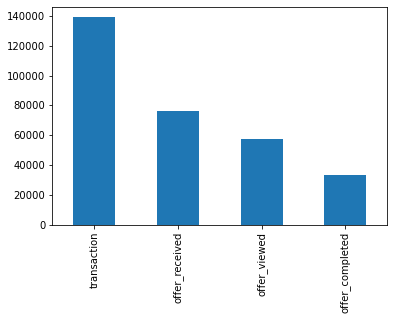

In [45]:
transcript.event.value_counts().plot(kind="bar");

In [46]:
trans_events = transcript.event \
    .apply(lambda x: False if x != "transaction" else True) 

trans_events.value_counts(normalize=True)

False    0.546696
True     0.453304
Name: event, dtype: float64

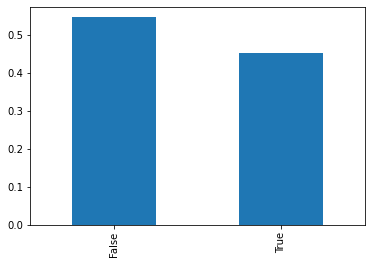

In [47]:
trans_events.value_counts(normalize=True).plot(kind="bar");

Event distribution in `transcript` table shows that `transaction` or "no offer" is still the top data at 45%. Combining offer events, they occupy 55% of the data, while not offered events is at 45%.

Next we're going to try to understand is time.

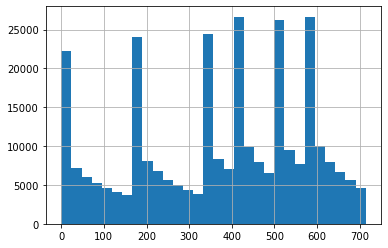

In [48]:
transcript.time.hist(bins=30);

In [49]:
transcript_diff = transcript.sort_values(["person_id", "time"])
transcript_diff["time_diffs"] = transcript_diff.groupby("person_id").time.diff()
transcript_diff = transcript_diff.sort_index()

print(transcript_diff.time_diffs.mean())
print(transcript_diff.time_diffs.median())

35.88187915754281
18.0


There are some noticeable spikes in the distribution. Dividing the estimated value of the spikes, they coincide with 0, **7**, **14**, 17, **21**, 24. The **bold** ones are week timeframes. Let's take note of that for now. Also, lot of events happening on the third week.

Also, time difference between events is at 36 hours. This can be a good note on designing the duration of offers.

Moving to `offer_id`.

In [50]:
transcript.offer_id.value_counts(normalize=True).sort_index(axis=0)

0     0.453304
1     0.058923
2     0.059445
3     0.038368
4     0.052855
5     0.044860
6     0.065699
7     0.066032
8     0.046667
9     0.062411
10    0.051436
Name: offer_id, dtype: float64

With large difference of `transaction` events, let's remove it to get a better view at the data.

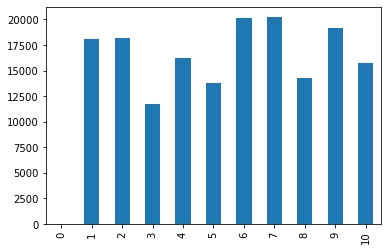

In [51]:
transcript[transcript.offer_id != 0].offer_id.value_counts().sort_index(axis=0).plot(kind="bar");

There are offers more than the others. This can be indication how consumers react to to the test or offer.

Let's move on to the `amount` and `reward`.

           bins    count
0      0.050000    816.0
1      0.093202    811.0
2      0.173732   1738.0
3      0.323842   3810.0
4      0.603653   7341.0
5      1.125231  12763.0
6      2.097471  17481.0
7      3.909761  18312.0
8      7.287935  24413.0
9     13.584974  37258.0
10    25.322882  13437.0
11    47.202765    257.0
12    87.987657    135.0
13   164.012167     69.0
14   305.724596    166.0
15   569.881675    146.0
16  1062.280000      NaN


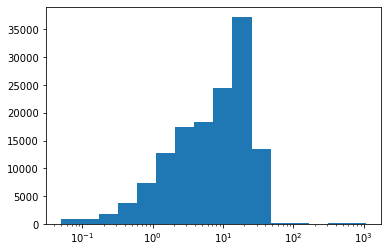

In [52]:
def plot_loghist(x, bins):
  _, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

  hist = pd.concat([pd.Series(logbins, name="bins"), pd.Series(np.histogram(x, bins=logbins)[0], name="count")], axis=1)
  print(hist)

  plt.hist(x, bins=logbins)
  plt.xscale('log')

plot_loghist(transcript[~transcript.amount.isna()].amount, 16)

We had to create a logarithmic histogram as there are super large values that can be considered outliers. The graph is a bit left skewed distribution with its peak at approximately 10 - 50 values.

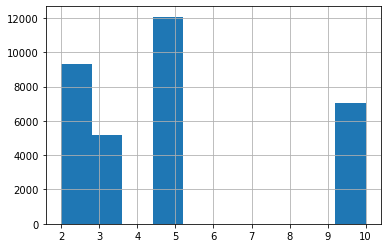

In [53]:
transcript.reward.hist();

Rewards are a bit conservative at most of them are at less than 5. The most expensive is at 10.

#### Bivariate and Multivariate

Let's understand further how `time` and `offer_id` works. Let's visually investigate on some random person.

In [54]:
transcript[transcript.person_id == 106].sort_values(["offer_id", "time"])

,person_id,event,time,offer_id,amount,reward
1426,106,transaction,198,0,22.49,NaN
1429,106,transaction,210,0,18.33,NaN
1430,106,transaction,252,0,11.80,NaN
1431,106,transaction,294,0,13.04,NaN
1433,106,transaction,342,0,12.34,NaN
1436,106,transaction,360,0,13.08,NaN
1437,106,transaction,402,0,15.26,NaN
1439,106,transaction,426,0,26.91,NaN
1440,106,transaction,456,0,25.31,NaN
1441,106,transaction,480,0,25.09,NaN


In [55]:
transcript[transcript.person_id == 106].sort_values("time")

,person_id,event,time,offer_id,amount,reward
1422,106,offer_received,0,7,NaN,NaN
1423,106,offer_viewed,96,7,NaN,NaN
1424,106,offer_received,168,7,NaN,NaN
1425,106,offer_viewed,180,7,NaN,NaN
1426,106,transaction,198,0,22.49,NaN
1427,106,offer_completed,198,7,NaN,2.0
1428,106,offer_completed,198,7,NaN,2.0
1429,106,transaction,210,0,18.33,NaN
1430,106,transaction,252,0,11.80,NaN
1431,106,transaction,294,0,13.04,NaN


In [56]:
transcript[transcript.duplicated(subset=["person_id", "event", "offer_id", "time"], keep=False)].head(10)

,person_id,event,time,offer_id,amount,reward
1427,106,offer_completed,198,7,NaN,2.0
1428,106,offer_completed,198,7,NaN,2.0
1555,111,offer_completed,480,10,NaN,2.0
1556,111,offer_completed,480,10,NaN,2.0
3110,233,offer_completed,564,1,NaN,10.0
3111,233,offer_completed,564,1,NaN,10.0
3416,251,offer_completed,426,2,NaN,10.0
3417,251,offer_completed,426,2,NaN,10.0
6617,477,offer_completed,510,1,NaN,10.0
6618,477,offer_completed,510,1,NaN,10.0


In [57]:
transcript[transcript.event == "transaction"].duplicated(subset=["person_id", "time"]).sum()

0

Here are more information regarding the events.
* `transaction` events are always `offer_id` 0
* `transaction` `time` does not reset
* `time` continuously move for each customer.
* `offer_completed` can occur before `offer_viewed`
* a person can receive the same type of offer multiple times.
* `transaction` are compound, can an offer be included or not

With this assumptions, these are the different customer interactions.
* Customer buys a coffee with no associated offer (`transaction` with no connected `offer_completed`)
* Customer receives an offer and ends there (only event for a customer is `offer_received`)
* Customer receives an offer, viewed it but did not do anything about it (`offer_received` and `offer_viewed` only)
* Customer received, viewed and finally avail the offer (`offer_received`, `offer_viewed`, `transaction` and `offer_completed`)
* Customer availed the offer without receiving nor viewing it (`offer_received`, `transaction` and `offer_completed`)

We can extract more data if we can create an offer group. This requires a bit of coding, so we'll follow the following logic:

* Iterate through the events in order of time
* If the event is `offer_received`, create a new offer group
* If the event is `offer_viewed`, add the event to the first offer group
* if the event is `offer_completed`, add the event to the first offer group
* There could only be one of these events in every group.

In [58]:
transcript_group = get_transcript_group(transcript)
transcript_group.head()

,person_id,event,time,offer_id,amount,reward,offer_group
0,4,offer_received,0,4,NaN,NaN,1.0
1,4,offer_viewed,6,4,NaN,NaN,1.0
2,4,transaction,132,0,19.89,NaN,0.0
3,4,offer_completed,132,4,NaN,5.0,1.0
4,4,transaction,144,0,17.78,NaN,0.0


In [59]:
transcript_seq = get_transcript_sequence(transcript_group)
transcript_seq.head()

,person_id,offer_group,event,offer_id,offer_success,completed,success
0,1,1.0,"[offer_received, offer_viewed]",10,failed_viewed,False,False
1,1,2.0,"[offer_received, offer_viewed]",5,failed_viewed,False,False
2,1,3.0,"[offer_received, offer_viewed, offer_completed]",7,success,True,True
3,1,4.0,"[offer_received, offer_viewed, offer_completed]",6,success,True,True
4,1,5.0,"[offer_received, offer_viewed]",7,failed_viewed,False,False


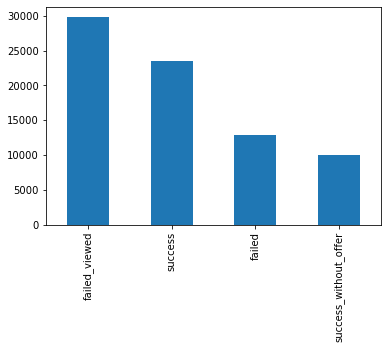

In [60]:
transcript_seq.offer_success.value_counts().plot(kind="bar");

In [61]:
transcript_seq.completed.value_counts(normalize=True)

False    0.559776
True     0.440224
Name: completed, dtype: float64

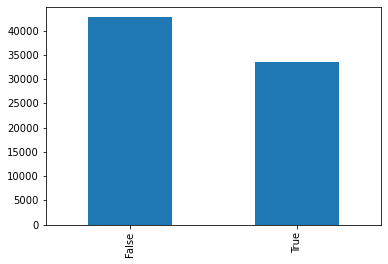

In [62]:
transcript_seq.completed.value_counts().plot(kind="bar");

Here we can now see the general success of the offers.

* `success` - the offer was received, viewed and completed
* `success_without_offer` - the offer was received and not viewed, but still completed
* `failed` - the offer was received, not viewed and not completed
* `failed_viewed` - the offer was received and viewed, but not completed

Among these categories, the success status are both `success` and `success_without_offer`, but the true success where the offer is effective is only `success`.

As we can see at the graphs above, we have more failed offers (56%) than successful ones (44%). In the breakdown, most of the failed offers are `failed_viewed` type.

> NOTE

> We can target later to predict not giving offer to `success_without_offer`, `failed` and `failed_viewed` types.

Next we can look at the distribution of `amount` mean per person. This is to view the spending capability of each person.

          bins   count
0     0.050000     4.0
1     0.088348     7.0
2     0.156109    11.0
3     0.275839    33.0
4     0.487399    94.0
5     0.861219   472.0
6     1.521746  2314.0
7     2.688876  3332.0
8     4.751158   876.0
9     8.395144  2422.0
10   14.833950  5459.0
11   26.211115  1295.0
12   46.314201   123.0
13   81.835710   100.0
14  144.601080    27.0
15  255.505478     8.0
16  451.470000     NaN


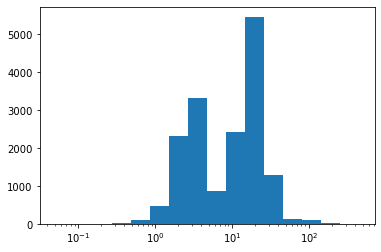

In [63]:
plot_loghist(transcript[~transcript.amount.isna()].groupby("person_id").amount.mean(), 16)

As we can see here, there's spike in average amount `2` and `10` per person. We can use this information to guide us when creating offers in the future.

Let's try to look at the reward distribution as well.

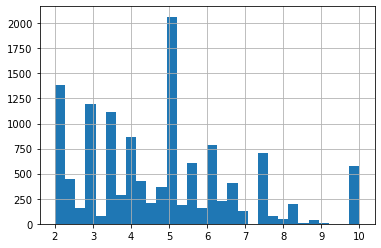

In [64]:
transcript[~transcript.reward.isna()].groupby("person_id").reward.mean().hist(bins=30);

Most reward availed in average per person is at `5`. This coincide with one of the `bogo` offers.

Let's move and take a look at the success rate of each offer.

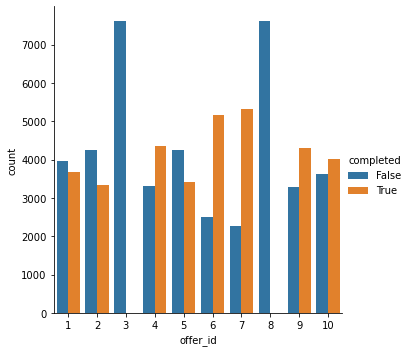

In [65]:
sns.catplot(data = transcript_seq, x="offer_id", hue="completed", kind="count");

In [66]:
transcript_seq.groupby("offer_id").completed.apply(lambda x: sum(x)/len(x))

offer_id
1     0.481588
2     0.438694
3     0.000000
4     0.567149
5     0.446009
6     0.674340
7     0.699882
8     0.000000
9     0.567428
10    0.526336
Name: completed, dtype: float64

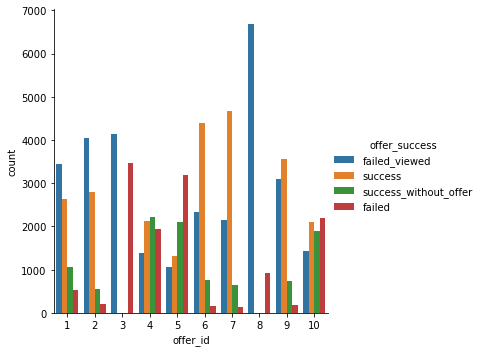

In [67]:
sns.catplot(data = transcript_seq, x="offer_id", hue="offer_success", kind="count");

This is an interesting information here. Offers 3 and 8 are 100% failure. While offers 6,7 have the highest success rate at 67% and 70% respectively. These are both of type `discount`.

3 and 8 offers are of type informational. This maybe inconclusive that they are not effective. The case probably is that informational offers have no `offer_completed` status that we can track of.

On the other hand, let's investigate closely the transaction types. Are there any increase in sales over time?

In [68]:
transcript_day = transcript.copy()

bins = np.arange(-1, 714 + 24, step=24)
labels = np.arange(1, int(np.ceil(714/24)) + 1)

transcript_day["day"] = pd.cut(transcript_day.time, bins=bins, labels=labels)

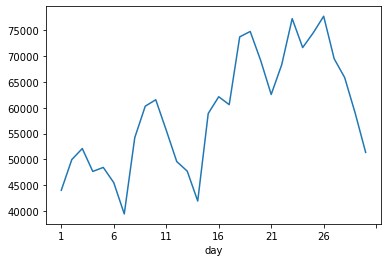

In [69]:
transcript_day[transcript_day.event == "transaction"] \
    .groupby("day") \
    .amount \
    .sum() \
    .plot(kind="line");

Even though there are dips in day 7 and 14, the increase is consistent. There must be something in the offers that are working.

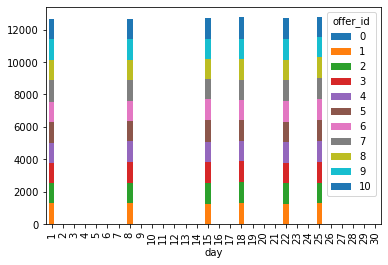

In [70]:
transcript_day[transcript_day.event == "offer_received"] \
    .groupby(["day", "offer_id"]) \
    .event \
    .count() \
    .reset_index() \
    .pivot("day", "offer_id", "event") \
    .plot(kind="bar", stacked=True);

Here we can notice that offers are given weekly (except for day 15 and 18). The different offers are sort of distributed equally on these days.

### Cross Table Analysis

It's a good thing we could understand which group should we focused on. Let's see some spending data in different age groups.

In [71]:
transcript_profile = pd.merge(transcript, profile_age_date, left_on="person_id", right_on="id")

transcript_profile.head()

,person_id,event,time,offer_id,amount,reward,id,gender,age,income,became_member_on,group,generation,month,year
0,4,offer_received,0,4,NaN,NaN,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
1,4,offer_viewed,6,4,NaN,NaN,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
2,4,transaction,132,0,19.89,NaN,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
3,4,offer_completed,132,4,NaN,5.0,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
4,4,transaction,144,0,17.78,NaN,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017


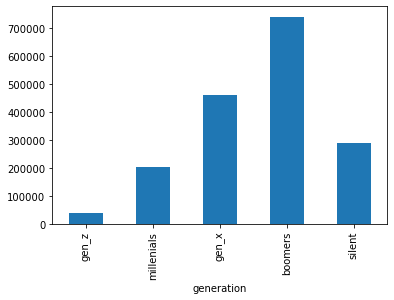

In [72]:
transcript_profile.groupby("generation").amount.sum().plot(kind="bar");

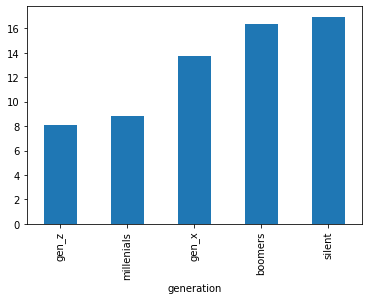

In [73]:
transcript_profile.groupby("generation").amount.mean().plot(kind="bar");

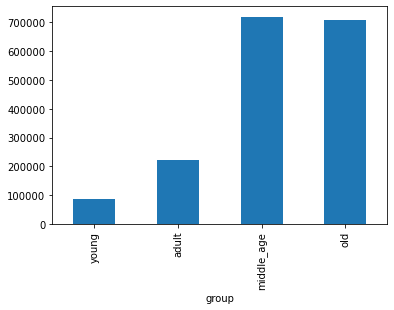

In [74]:
transcript_profile.groupby("group").amount.sum().plot(kind="bar");

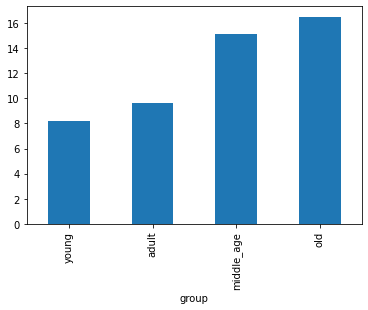

In [75]:
transcript_profile.groupby("group").amount.mean().plot(kind="bar");

`middle_age` and `boomers` brings in the most money, however, `old` and `silent` group tends to spend more. It also shows that the older you get, the more expensive you are willing to spend.

How does the age groups relates to offer success?

In [76]:
transcript_seq_profile = pd.merge(transcript_seq, profile_age_date, left_on="person_id", right_on="id")
transcript_seq_profile.head()

,person_id,offer_group,event,offer_id,offer_success,completed,success,id,gender,age,income,became_member_on,group,generation,month,year
0,1,1.0,"[offer_received, offer_viewed]",10,failed_viewed,False,False,1,NaN,NaN,NaN,2017-02-12,NaN,NaN,2,2017
1,1,2.0,"[offer_received, offer_viewed]",5,failed_viewed,False,False,1,NaN,NaN,NaN,2017-02-12,NaN,NaN,2,2017
2,1,3.0,"[offer_received, offer_viewed, offer_completed]",7,success,True,True,1,NaN,NaN,NaN,2017-02-12,NaN,NaN,2,2017
3,1,4.0,"[offer_received, offer_viewed, offer_completed]",6,success,True,True,1,NaN,NaN,NaN,2017-02-12,NaN,NaN,2,2017
4,1,5.0,"[offer_received, offer_viewed]",7,failed_viewed,False,False,1,NaN,NaN,NaN,2017-02-12,NaN,NaN,2,2017


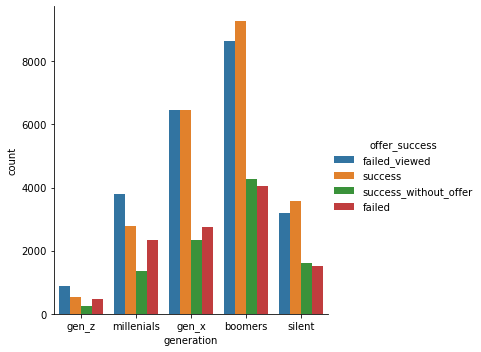

In [77]:
sns.catplot(data = transcript_seq_profile, x="generation", hue="offer_success", kind="count");

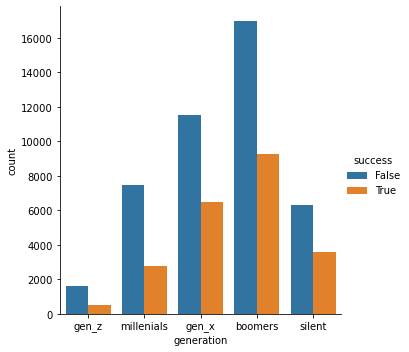

In [78]:
sns.catplot(data = transcript_seq_profile, x="generation", hue="success", kind="count");

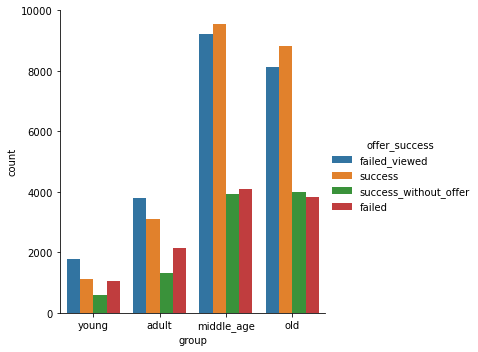

In [79]:
sns.catplot(data = transcript_seq_profile, x="group", hue="offer_success", kind="count");

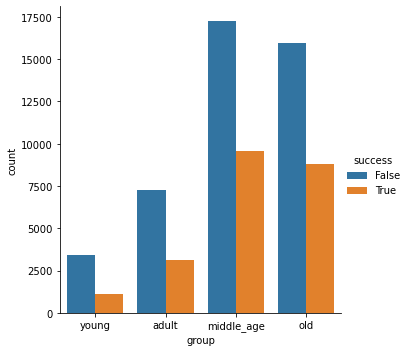

In [80]:
sns.catplot(data = transcript_seq_profile, x="group", hue="success", kind="count");

We can see here that we have a better success rate for `middle_age` group and `boomers` generation. However, all in all, we have a high rate of failure across, compared to true successes. It maybe a misconception that the older you get, you're less likely use technology to view the offers.

Let's also look at how each group spends through time.

In [81]:
transcript_day_profile = pd.merge(transcript_day, profile_age_date, left_on="person_id", right_on="id")
transcript_day_profile.head()

,person_id,event,time,offer_id,amount,reward,day,id,gender,age,income,became_member_on,group,generation,month,year
0,4,offer_received,0,4,NaN,NaN,1,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
1,4,offer_viewed,6,4,NaN,NaN,1,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
2,4,transaction,132,0,19.89,NaN,6,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
3,4,offer_completed,132,4,NaN,5.0,6,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017
4,4,transaction,144,0,17.78,NaN,7,4,F,75.0,100000.0,2017-05-09,old,silent,5,2017


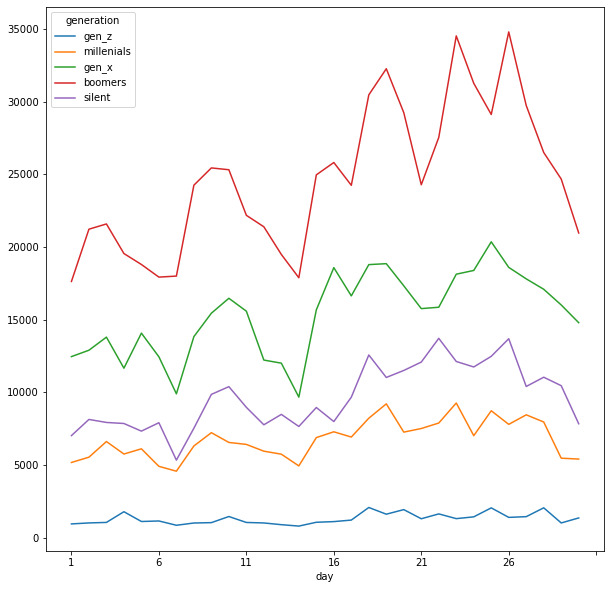

In [82]:
transcript_day_profile.groupby(["generation", "day"]).amount.sum().reset_index().pivot("day", "generation", "amount").plot(kind="line", figsize=(10, 10));

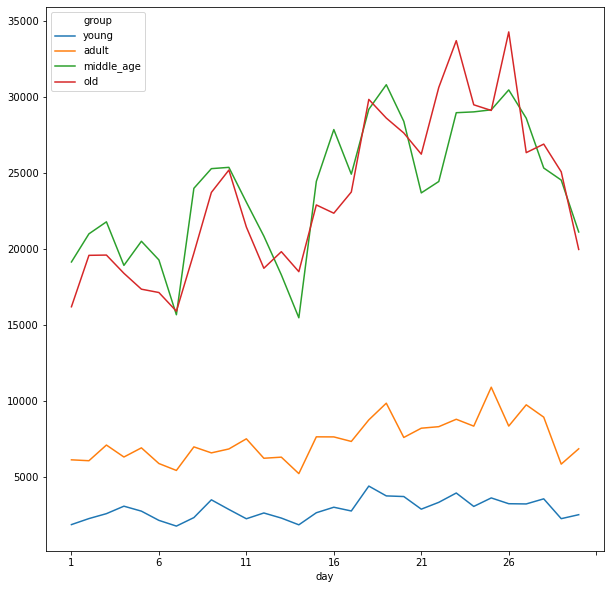

In [83]:
transcript_day_profile.groupby(["group", "day"]).amount.sum().reset_index().pivot("day", "group", "amount").plot(kind="line", figsize=(10, 10));

The rate of increase is more obvious with generations `gen_x`/`boomers` and groups `old`/`middle_age`. It's interesting information that `middle` and `old_age` almost the same spending through time when they are viewed per `group`.

There's one more item we'll try to assess here. Informational type of offers are inconclusive since they have no `offer_completed` event. Let's see if we can find any pattern within the tables.

In [84]:
transcript_portfolio = transcript_day.merge(portfolio, left_on="offer_id", right_on="id", how="left")
transcript_portfolio = transcript_portfolio.rename(columns={"reward_x": "reward", "reward_y": "offer_reward"})
transcript_active = get_transcript_active(transcript_portfolio)

In [85]:
transcript_active[transcript_active.person_id==106][["event", "time", "offer_id", "duration", "active_offers"]]

,event,time,offer_id,duration,active_offers
1422,offer_received,0,7,10.0,[7]
1423,offer_viewed,96,7,10.0,[7]
1424,offer_received,168,7,10.0,"[7, 7]"
1425,offer_viewed,180,7,10.0,"[7, 7]"
1426,transaction,198,0,NaN,"[7, 7]"
1427,offer_completed,198,7,10.0,"[7, 7]"
1428,offer_completed,198,7,10.0,"[7, 7]"
1429,transaction,210,0,NaN,"[7, 7]"
1430,transaction,252,0,NaN,[7]
1431,transaction,294,0,NaN,[7]


In [86]:
transcript_exp = transcript_active[transcript_active.event == "transaction"].explode("active_offers")
transcript_exp["offered_info"] = transcript_exp.active_offers.isin([3, 8])

transcript_exp.head()

,person_id,event,time,offer_id,amount,reward,day,id,offer_type,channels,offer_reward,difficulty,duration,active_offers,offered_info
2,4,transaction,132,0,19.89,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,4,False
4,4,transaction,144,0,17.78,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,4,False
7,4,transaction,222,0,19.67,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,8,True
8,4,transaction,240,0,29.72,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,8,True
9,4,transaction,378,0,23.93,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,None,False


In [87]:
transcript_info_trans = transcript_exp[(transcript_exp.event == "transaction") & (transcript_exp.active_offers.isin([None, 3, 8]))]
transcript_info_trans.offered_info.value_counts()

False    17090
True     16715
Name: offered_info, dtype: int64

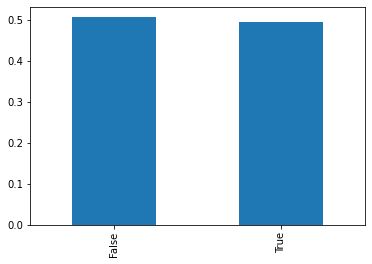

In [88]:
transcript_info_trans.offered_info.value_counts(normalize=True).plot(kind="bar");

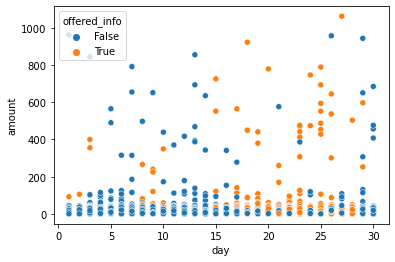

In [89]:
sns.scatterplot(data=transcript_info_trans, x="day", y="amount", hue="offered_info", x_jitter=0.5);

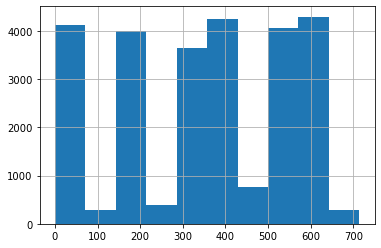

In [90]:
transcript[transcript.offer_id.isin([3, 8])].time.hist();

We are able to map the active offers on each timeframe, which gains me more insight if there are active informational offers when transactions are made. The data however is not that much conclusive as we observe, that the amount of buyers when there's no active informational offer is almost the same as when there's active informational offers.

In the distribution, we can see that there's more offers on the latter part which is consistent on how consumers reacted to informational offers.

## Summary

The data is simulation that mimics customer behaviour of Starbucks rewards mobile app. As part of this exercise, we are provided with 3 tables:

* Portfolio - a list of offers given and some information about those offers
* Profile - contains some basic user information
* Transcript - running timeline of different customer events recorded in the mobile app

**Portfolio**

The first thing we looked it is the portfolio table. Not much on this table, it contains only `10` offers varying from discount, buy-one-get-one and informational. 

These offers are sent out through one or combination of the following channels: web, email, mobile or social media. Most of the offers are sent out through all these channels. With the offers, the more favored types are `bogo` and `discount` at 4 occurrence, while there are only 2 `informational` offers at 2. This maybe an indication that among the offer types, `informational` is the least effective, but we can find that out later.

On the other hand, `informational` is the cheapest among the types as it takes zero rewards on the part of the business, while the most expensive are the `bogo` ones which are giving out at 100% of the minimum required spend. `discount` types are ranging from 20% to 40% of the total money spent of the customer.

_Features:_

id (int) 
- offer id

offer_type (category) 
- type of offer [bogo, discount or informational]

difficulty (int) 
- minimum required spend to complete offer. It is not stated in the details but we assume all monetary features in the different datasets are in the same unit

reward (int) 
- reward for completing an offer. We assume as well that this has the same unit as difficulty

duration (int)
- days, time for offer to be open

channels (list of category)
- list of channels that the offer is sent out through [web, email, mobile, social media]

**Profile**

This table is the customer table. Contains very minimal profile but we are able to extract additional ones.

The table contains 17000 records, but it has 2175 missing values. The missing values are the same on 3 features, `gender`, `age` and `income`. I'm thinking of 2 different types of registered user, or there's a 2 phase in their registration process.

The table, consists of 57% male, 41% female and 1% unspecified. At lower income bracket, male has more members than female.

From the age, I was able to retrieve 2 new features, age group and generations.

_Age Group:_

* 18-25: Young
* 26-40: Adult
* 41-60: Middle Age
* 61-100: Old

_Generations:_

Since the last record was 2018, I'm assuming that the data is from that year. I used that as an anchor to retrieve the generations data.

* 17-21: Generation Z
* 22-37: Millenials
* 38-53: Generation X
* 54-72: Boomers
* 73-101: Silent

Ages 50-60 has the most coffee drinkers [mean: 54.4, median: 55, mode: 58]. This age threads within `middle_age` and `boomers` as throughout the analysis, these groups spends more on coffee. The gender distribution of persons in profile, both male and female peaks at around ages 50-60 as well.

Moving on to membership, the data is ranging from 2013 to 2018. Through these years we can see consistent increase in membership with a dip in 2018, maybe because the membership data ended midway that year (July 2018). Each year, there are more male new joiners than female except on year 2016 but only at a very small margin.

Along with the membership, there's a sudden burst of new joiners from August 2017 to January 2018. This is consistent across different age group and generations.

_Features:_

age (int)
- age of the customer, assuming that this is on the year 2018

became_member_on (datetime)
- date when customer created an app account

gender (category)
- gender of customer [M, F, O]

id (int)
- customer ID

income (float)
- customer's income

_Derived:_

age_group (category):
- customer's age grouping [young, adult, middle_age, old]

generations (category):
- customer's generation, this maybe important as it can be noted that these generations usually have different perspective in a lot of things [gen_z, millenials, gen_x, boomers, silent]

**Transcript**

Perhaps the most important table among the three. Transcript contains the series of events for customer.

Events:

_transaction_
- this is the data that is recorded when a customer actually buys something. Along with this event, it contains the amount spent on the transaction. It is not documented how transaction relates to any offer. However, we can notice that we can somehow relate it if the transaction have the same time as the `offer_completed` event. However, it's more tricky to just mark the offer to the transaction as sometimes there's this situation that a transaction is composed of multiple offers and non-offers. Another tricky one is how to connect the informational offers to transactions.

_offer_received_
- event recorded when a customer receives an offer.

_offer_viewed_
- event recorded after customer receives an offer and views it.

_offer_completed_
- event recorded when customer completes an offer. This however does not properly record completion for informational offers. We explored the data and found that we can tie this up with `transaction` events as they have the same timestamp.

The time works where the customer time all starts at zero. Based on the maximum number of time the offer lasted for 30 days. It's a presumption that everyone receives the offer at the same time and perhaps ended as well at the same time. However, we don't when did this actually took place.

In the span of 30 days, offers starts every week except after the first 2 weeks, when they done bi-weekly. Offer are distributed evenly on those days.

We were able to compress and summarize the transcript and find out the success rate of the offers, except for the informational. Based on what we've found out, currently we have a bad success rate across different generations and age groups. This can be an opportunity to optimize and target who gets the offers. All in all, we found increase in sales overtime, but not that much. It's currently inconclusive if this is attributed to the offers.

There are 4 different observed outcomes for the offers.

* successful
   - the offer was received, viewed and completed
* successful without offer
   - the offer was received and completed even without viewing it
* failed
   - the offer was received but never been viewed nor completed
* viewed but failed
   - the offer was received and viewed but never completed

Among this 4 scenario, we can say that the only successful offer is the first one. The other scenario failed as the offer is never effective for the customer.

Getting the time difference in between events, it was observed that the time difference mean is at 36 hours (1.5 days), we can take note of this when setting durations for offers. 

__Features:__

* event (category)
   - the record event description [transaction, offer_received, offer_viewed, offer_completed].`transaction` events are the actual purchase that may or may not be linked with offers. No `offer_completed` for informational offers, but does not mean that the purchase is affected by it.

* person (int)
   - the customer id

* time (int)
   - hours since the test started. For each customer, the time starts at zero and ran for 30 days (714). There are patterns that same time as previous may relate to linking a transaction to offer.

* offer_id (category)
   - the offer linked to the record event. Zero if it's not linked to any offers. [0-9]

* amount (float)
   - the amount spent on the transaction. This only has values for `transaction` events.

* reward (float)
   - the reward amount given for that transaction. This only has values for `offer_completed` events.

__Derived:__

* offer_success (category)
   - the outcome of the offer [successful, successful_without_offer, failed, viewed_but_failed]

* completed (bool)
   - whether the offer was completed or not. The value was retrieved from when there at least one `offer_completed` event.

* success (bool)
   - whether the offer is successful or not. This if all events for that offer are met (`offer_received`, `offer_viewed`, `offer_completed`).

* offer_group (int)
   - bundles events into a group. Max of this per person will also the number of events received.

* active_offers (list of category)
   - records the active offers for that customer based on duration.